## Project 2
*Alexander Laloi Dybdahl, Viktor Ellevseth, Harald Hobbelhagen*

### Importing libraries

In [3]:
# %load_ext autoreload
%autoreload 2

from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from kerastuner.tuners import Hyperband

# ----------- Importing necessary functions ----------- #
from helper_functions import *
from augmentation_functions import *
from unet_functions import *
from prediction_functions import *

### Performing loading

In [4]:
root_dir = "training/"
n = 100
imgs, gt_imgs = load_dataset(root_dir, load_images_from_directory, max_images=n)


Loading 100 original images
Loading 100 ground truth images


### Defining parameters

In [5]:
# Constant parameters
original_height, original_width = 400, 400      # Image sizes
validation_size = 0                             # Validation set for patch threshold test
test_size = 0.05                                # Test set for CNN fitting
random_state = 42                               # Random seed for train/test/validation split
threshold = 0.2                                 # Threshold for patch prediction

# U-net hyperparameters
activation='relu'
depth = 4
dropout_rate = 0.1
optimizer = 'adam'
loss = 'binary_crossentropy'
metrics = ['accuracy']
patience = 3
batch_size = 10
epochs = 25

### Performing augmentation

In [6]:
# Choose augmentation options
augment_options = {
    "color_augmentation": False,
    "rotation": {"angles": [0, 90, 135]},
    "deformation": {"alpha": 34, "sigma": 4},
    "cropping": {"height": 200, "width": 200},
    "flipping": True,
    "scaling": {"factors": (0.8, 1.2)},
    "shearing": {"range": (-0.4, 0.4)},
    "noise": {"type": "gaussian", "mean": 0, "std": 0.4}
}

# Split data for validation set
if validation_size:
    imgs, X_validation, gt_imgs, y_validation = train_test_split(imgs, gt_imgs, test_size=validation_size, random_state=random_state)
    X_validation = np.array(X_validation)
    y_validation = np.array(y_validation)
    X_validation = X_validation.astype('float32')
    y_validation = (y_validation > 0.5).astype(np.float32)

# Apply augmentations
augmented_imgs, augmented_gt_imgs = augment_data(imgs, gt_imgs, augment_options, (original_height, original_width))

# Split data into training and test set
X_train, X_test, y_train, y_test = train_test_split(augmented_imgs, augmented_gt_imgs, test_size=test_size, random_state=random_state)

# Normalization
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# Make sure that the gt are binary 0 and 1
y_train = (y_train > 0.5).astype(np.float32)
y_test = (y_test > 0.5).astype(np.float32)


### Dataset summary

#### Train images

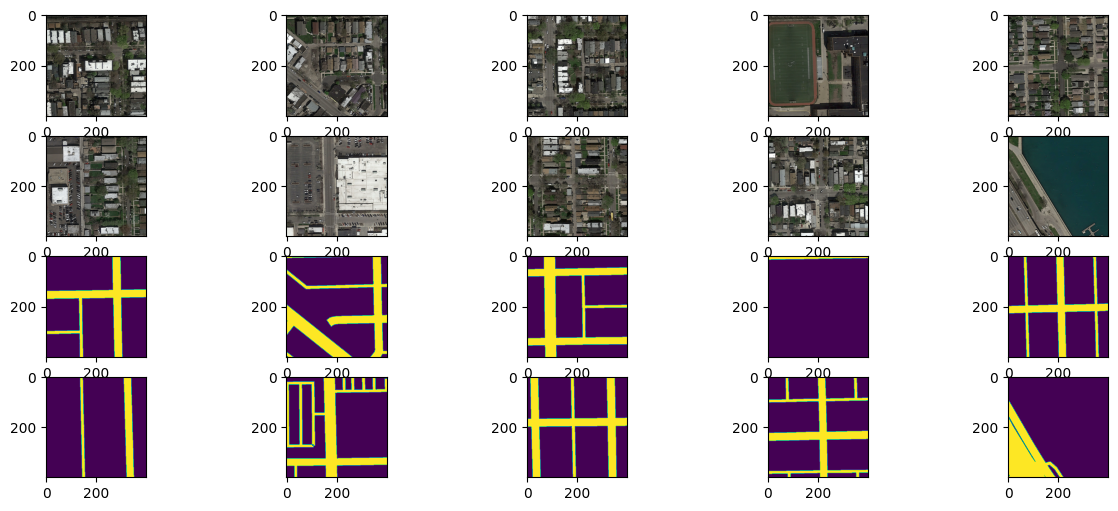

In [7]:
ten_images = X_train[:10]
ten_train_y = y_train[:10]
fig, axes = plt.subplots(4, 5, figsize=(15, 6))
axes = axes.flatten()
for i in range(10):
    axes[i].imshow(ten_images[i])
    axes[i+10].imshow(ten_train_y[i])
plt.show()

#### Validation images

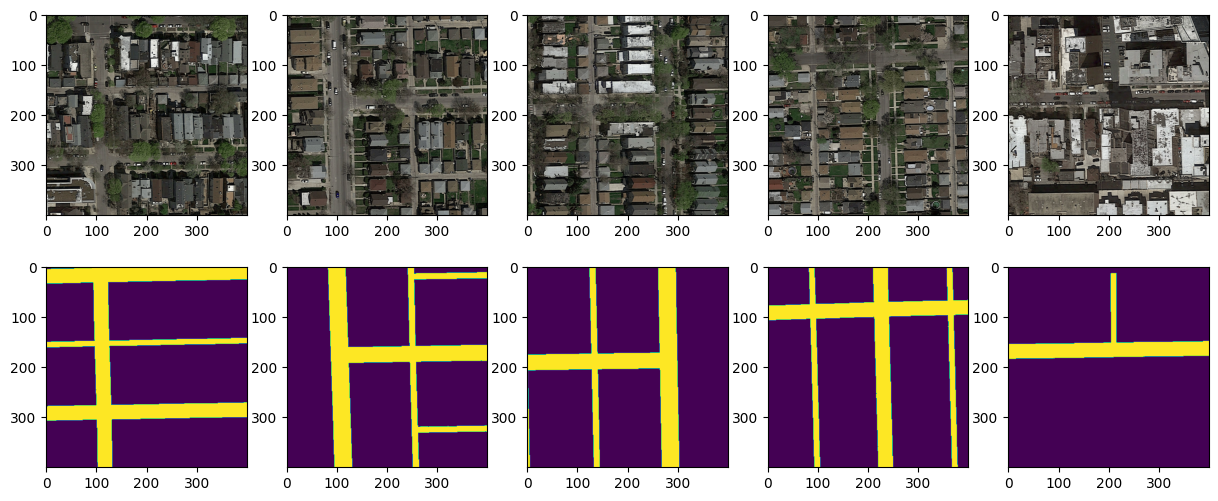

In [8]:
five_images = X_test[:5]
five_train_y = y_test[:5]
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()
for i in range(5):
    axes[i].imshow(five_images[i])
    axes[i+5].imshow(five_train_y[i])
plt.show()

#### Summary

In [9]:
print("Dataset Summary:\n")

print(f"Training Images:\n - Min Value: {X_train.min():.4f}\n - Max Value: {X_train.max():.4f}\n - Shape: {X_train.shape}")
print(f"Test Images:\n - Min Value: {X_test.min():.4f}\n - Max Value: {X_test.max():.4f}\n - Shape: {X_test.shape}")
# print(f"Validation Images:\n - Min Value: {X_validation.min():.4f}\n - Max Value: {X_validation.max():.4f}\n - Shape: {X_validation.shape}")

print(f"Training Masks:\n - Min Value: {y_train.min():.4f}\n - Max Value: {y_train.max():.4f}\n - Shape: {y_train.shape}")
print(f"Test Masks:\n - Min Value: {y_test.min():.4f}\n - Max Value: {y_test.max():.4f}\n - Shape: {y_test.shape}")
# print(f"Validation Masks:\n - Min Value: {y_validation.min():.4f}\n - Max Value: {y_validation.max():.4f}\n - Shape: {y_validation.shape}")

Dataset Summary:

Training Images:
 - Min Value: 0.0000
 - Max Value: 1.0000
 - Shape: (95, 400, 400, 3)
Test Images:
 - Min Value: 0.0000
 - Max Value: 1.0000
 - Shape: (5, 400, 400, 3)
Training Masks:
 - Min Value: 0.0000
 - Max Value: 1.0000
 - Shape: (95, 400, 400, 1)
Test Masks:
 - Min Value: 0.0000
 - Max Value: 1.0000
 - Shape: (5, 400, 400, 1)


### Building U-net

#### Loading pretrained keras model

In [11]:
model = models.load_model('models/model_0.0092_0.9881_0.0053_0.9925.keras')


#### Printing model details

In [23]:
print_layer_details(model)

### Performing auto tuning

In [24]:
tuner = Hyperband(build_unet_hp,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='my_dir',
                     project_name='ml_course_road_segmentation')

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [28]:
tuner.search(X_train, y_train, epochs=50, validation_split=0.2, callbacks=[stop_early])

In [29]:
# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('start_filters')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")

print(best_hps.get('start_filters'))
print(best_hps.get('learning_rate'))
print(best_hps.get('dropout_rate'))
print(best_hps.get('activation'))
print(best_hps.get('kernel_size'))
print(best_hps.get('optimizer'))
print(best_hps.get('loss'))


The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 15 and the optimal learning rate for the optimizer
is 0.11.

15
0.11
0.22
relu
7
adam
mean_squared_error


### Performing fitting

In [30]:
model = tuner.hypermodel.build(best_hps)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 400, 400, 3)]        0         []                            
                                                                                                  
 conv2d_11 (Conv2D)          (None, 400, 400, 15)         2220      ['input_2[0][0]']             
                                                                                                  
 dropout_5 (Dropout)         (None, 400, 400, 15)         0         ['conv2d_11[0][0]']           
                                                                                                  
 conv2d_12 (Conv2D)          (None, 400, 400, 15)         11040     ['dropout_5[0][0]']           
                                                                                            

#### Fitting hyperparameter tuned model

In [12]:
callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=3, monitor='val_loss'),
        tf.keras.callbacks.TensorBoard(log_dir='logs')]

history = model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=25, epochs=1, callbacks=callbacks)



4/4 [==============================] - 68s 17s/step - loss: 0.0084 - accuracy: 0.9885 - val_loss: 0.0103 - val_accuracy: 0.9862


#### Fitting hyperparameter tuned model using class weighting

In [41]:
labels = y_train.flatten()
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=labels)
class_weights = {0: class_weights[0], 1: class_weights[1]}

callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=3, monitor='val_loss'),
        tf.keras.callbacks.TensorBoard(log_dir='logs')]

history = model.fit(X_train, y_train, class_weight=class_weights, validation_data=(X_test, y_test), batch_size=25, epochs=3, callbacks=callbacks)

### Saving the fitted model 

In [34]:
message = ""
save_model_with_history_info(model, history, message)

### Plotting training loss vs validation loss

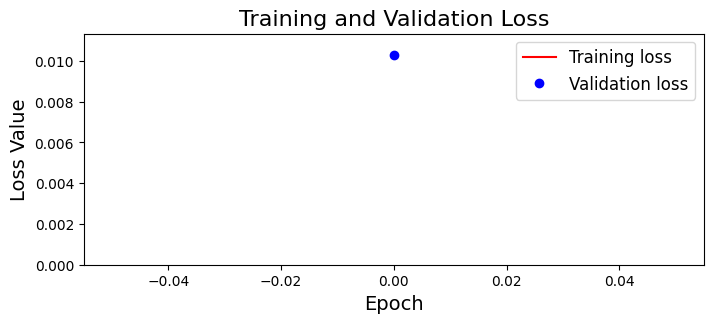

In [13]:
plot_training_validation_loss(history)

### Displaying prediction on test set

#### Prediction test patches

1/1 [==============================] - 1s 631ms/step


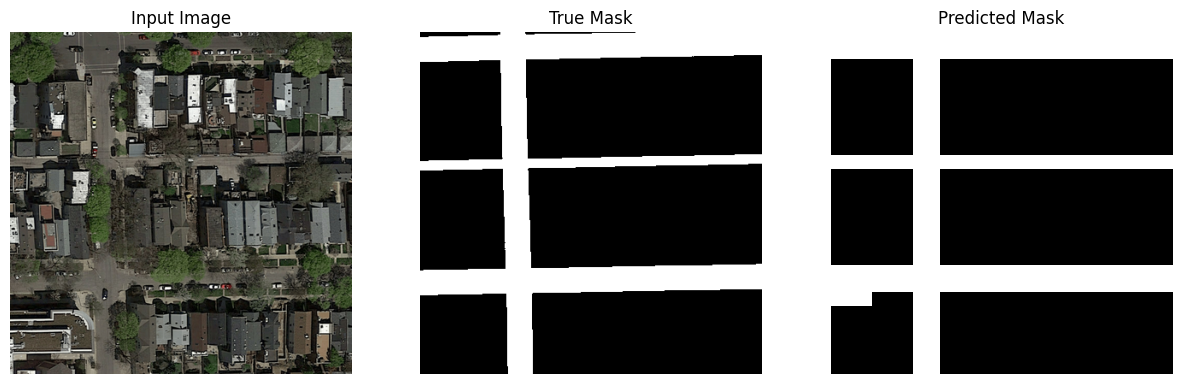

In [16]:
# Displaying arbitrary image
i = random.randint(0, len(X_test) - 1)
sample_image = X_test[i]
sample_mask = y_test[i]

# Predict the mask for the sample image
prediction = model.predict(sample_image[tf.newaxis, ...])[0]
predicted_mask = (prediction > 0.5).astype(np.uint8)

# Convert the predicted mask into patches
predicted_majority_patches = predictions_to_thresholded_patches(predicted_mask, threshold=0.25)

# Display the original image, true mask, and predicted mask
display([sample_image, sample_mask, predicted_majority_patches])

#### Predicting test pixels

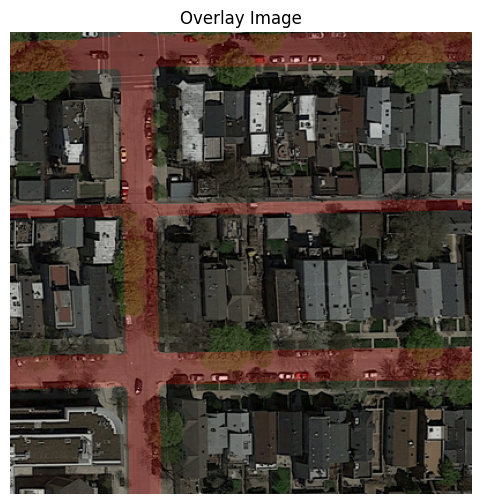

In [19]:
display_overlay(sample_image, predicted_mask)

### Parameter tuning for threshold for predicting patches

In [59]:
# Performing parameter tuning for predicting patches
thresholds = [0.1, 0.2, 0.25, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
f1_scores = evaluate_thresholds_batch(X_test, y_test, model, thresholds)
for threshold, score in f1_scores.items():
    print(f"Threshold: {threshold}, F1 Score: {score:.4f}")

1/1 [==============================] - 1s 830ms/step
Threshold: 0.1, F1 Score: 0.9759
Threshold: 0.2, F1 Score: 0.9773
Threshold: 0.25, F1 Score: 0.9768
Threshold: 0.3, F1 Score: 0.9756
Threshold: 0.4, F1 Score: 0.9723
Threshold: 0.5, F1 Score: 0.9680
Threshold: 0.6, F1 Score: 0.9634
Threshold: 0.7, F1 Score: 0.9577
Threshold: 0.8, F1 Score: 0.9483
Threshold: 0.9, F1 Score: 0.9324


### Loading test set images and predict

In [14]:
# Loading images
test_root_dir = "test_set_images"
test_images = load_images_from_subfolders(test_root_dir, n=50)

In [17]:
# Predicting images
predictions = predict_images(model, test_images)

1/1 [==============================] - 1s 682ms/step


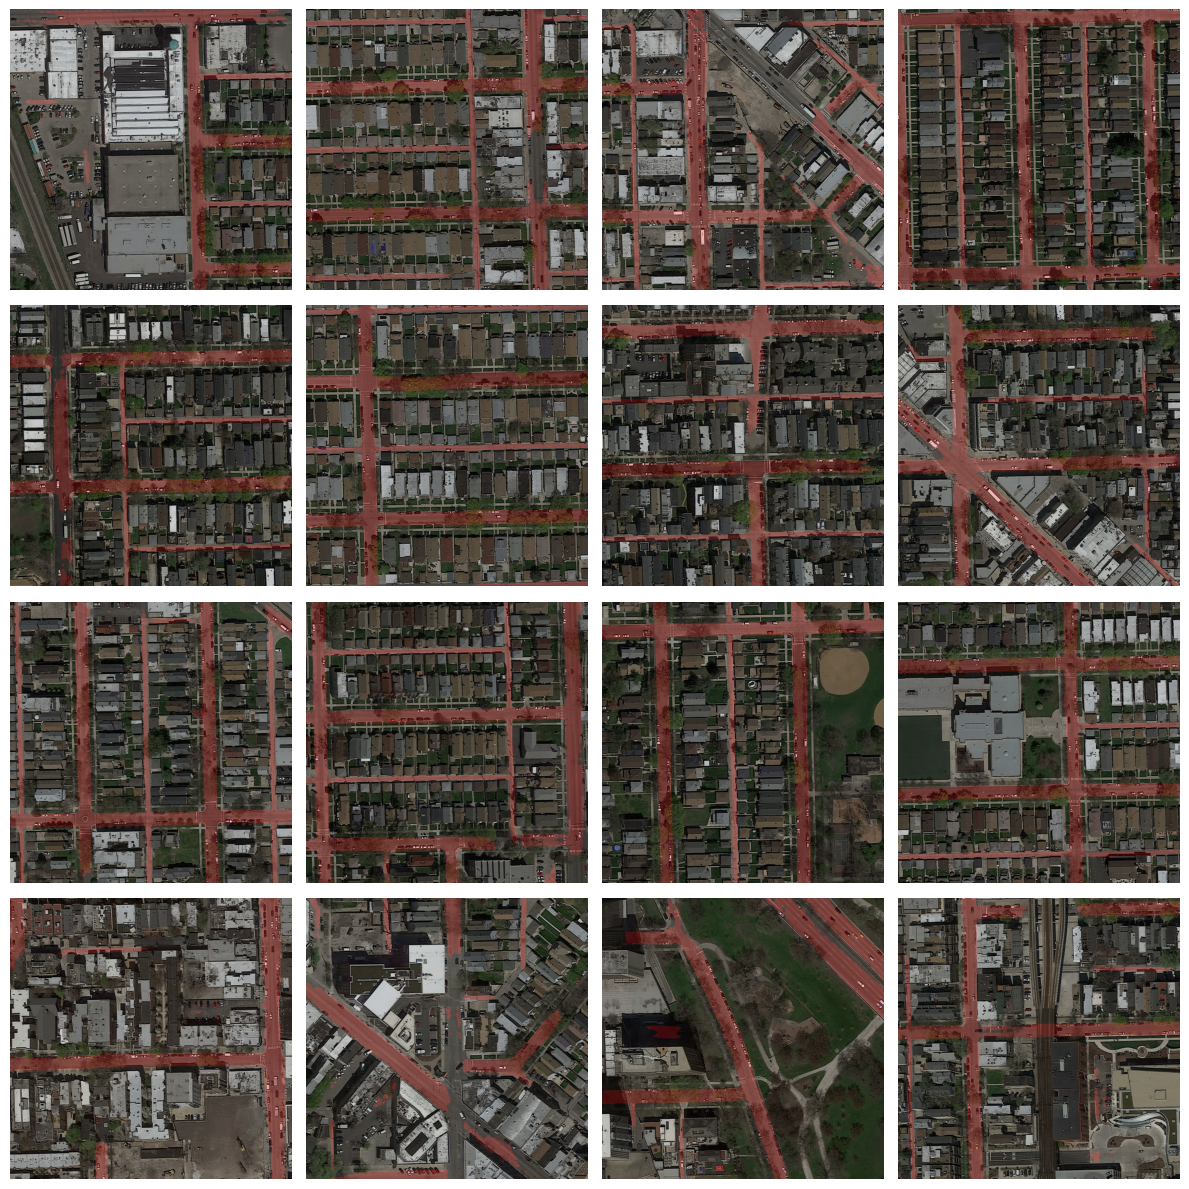

In [18]:
# Displaying arbitrary images
display_multiple_overlays(test_images, predictions, grid_size=4)

### Creating submission csv

In [572]:
# Saving to submission file
threshold=0.2
submission_df = create_submission_entries(predictions, threshold=threshold)
submission_message = ""
save_submission_to_csv(submission_df, f'submissions/sample_submission_{str(threshold)}_{submission_message}.csv')